*Ensemble Modeling with Skewed Datasets*
==================================

Here's a quick tutorial about how to use ensemble techniques with undersampling to get good results on an imbalanced data set. I'm going to stick with a very basic model (Adaboost with 100 Decision Tree Stumps) and just work on improving the model by changing the amount of training data I feed the model. The point of this kernel isn't to adjust the hyperparameters to find the best model, it's just to demonstrate how powerful ensembling can be on a skewed dataset.

_________________________
We'll look at three cases:
1. Adaboost model with no undersampling.
2. Adaboost model with undersampling.
3. Ensembled model with undersampling.

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.calibration import calibration_curve

In [8]:
def load_fraud_data(filename):
    df_data = pd.read_csv(filename)
    return df_data

df_data = load_fraud_data('/mnt/c/Users/Mangarella/Dropbox/Kaggle/creditcard.csv')

So let's start with the normal setup of our X and y data. Don't worry about the 'Class' column being kept in X_data, I'll pass through the slice X_data[ls_features] when I fit my classifier later on. We'll also add a confusion matrix plotting function to visualize our model performance. 

In [23]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    
def classification_setup(df_data):
    '''Returns X_data, y_data, ls_features'''
    X_data, y_data = df_data, df_data['Class']
    ls_features = list(X_data.keys())
    class_index = ls_features.index('Class')
    ls_features.pop(class_index)
    return X_data, y_data, ls_features

X_data, y_data, ls_features = classification_setup(df_data)

**1. Adaboost model with no undersampling.**
---------
Now we're ready to try our first approach.

Confusion matrix, without normalization


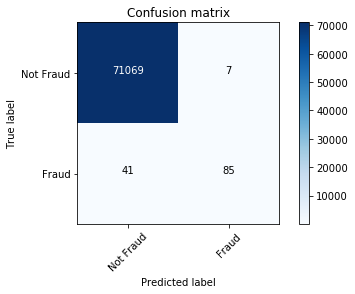

In [24]:
def adaboost_no_undersample(X_data, y_data):
    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data)
    dt_clf = DecisionTreeClassifier(max_depth = 1)
    ada_real = AdaBoostClassifier(base_estimator = dt_clf, 
                                  learning_rate = 0.1, 
                                  n_estimators = 100)
    ada_real.fit(X_train[ls_features], y_train)
    y_pred = ada_real.predict(X_test[ls_features])
    test_conf = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(test_conf, classes = ['Not Fraud', 'Fraud'])

adaboost_no_undersample(X_data, y_data)

Not the worst, but it doesn't look too great. Though technically the "accuracy" of the model is >99%. There's a high amount of false negatives (bottom left), which are the most crucial mistakes for a fraud problem. The only plus is the model seems to have very little false positives (this trend won't continue.)

**2. Adaboost model with undersampling.**
---------
So let's try undersampling. We'll drastically reduce the size of the train and test set so that the proportions of fraud and non-fraud cases are equal. We'll also create 10 folds, to eyeball if there's any significant variance in our model on this limited data.

In [25]:
def under_sample_kfold(X_data, y_data, n_folds = 10):
    '''Returns list of 10 (default) folds of
    X_train, X_test, y_train, y_test data'''
    
    pos_events = X_data[X_data['Class'] == 1]
    neg_events = X_data[X_data['Class'] == 0]
    
    #Randomize and pick same n number of events
    number_pos_events = len(pos_events)  
    undersampled_folds = []

    for fold in range(0, n_folds):
        pos_events = pos_events.reindex(np.random.permutation(pos_events.index))
        neg_events = neg_events.reindex(np.random.permutation(neg_events.index))
        undersampled_events = pd.concat([neg_events.head(number_pos_events), pos_events])
        X_data_u, y_data_u = undersampled_events, undersampled_events['Class']
        X_train_u, X_test_u, y_train_u, y_test_u = train_test_split(X_data_u, y_data_u, test_size=0.3)
        undersampled_folds.append([X_train_u, X_test_u, y_train_u, y_test_u])
    return undersampled_folds


folds = under_sample_kfold(X_data, y_data)

The following function can be run with the test set derived from the "balanced" undersampled test set, or from a test set that includes all of the data minus the train data to more accurately the actual class proportions of the data.

In [26]:
def adaboost_undersample(folds, full_test_set = False):
    
    for fold in folds:
        X_train, X_test, y_train, y_test = fold[0], fold[1], fold[2], fold[3]
    
        dt_clf = DecisionTreeClassifier(max_depth = 1)
        ada_real = AdaBoostClassifier(base_estimator = dt_clf, 
                                      learning_rate = 0.1, 
                                      n_estimators = 100)
        ada_real.fit(X_train[ls_features], y_train)

        if full_test_set == False:
            y_pred = ada_real.predict(X_test[ls_features])
            test_conf = confusion_matrix(y_test, y_pred)
            plot_confusion_matrix(test_conf, classes = ['Not Fraud', 'Fraud'])
    
        else:
            X_train_and_test = pd.concat([X_train, X_data])
            X_test_full = (X_train_and_test.reset_index()
                                           .drop_duplicates(subset= 'index', keep= False)
                                           .set_index('index'))
            y_test_full = X_test_full['Class']
        
            #Eval
            y_pred = ada_real.predict(X_test_full[ls_features])
            test_conf = confusion_matrix(y_test_full, y_pred)
            plot_confusion_matrix(test_conf, classes = ['Not Fraud', 'Fraud'])

2a. Undersampling with undersampled test set.
----------------------------------------------------------
Let's run this first with just the undersampled test set.

Confusion matrix, without normalization


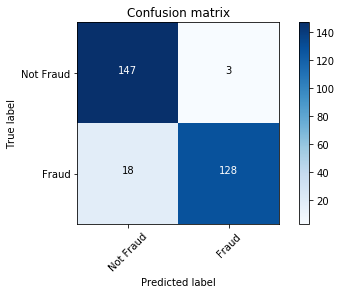

In [29]:
#This is only one fold for brevity, but feel free to modify the code to see there's minimal variation
#between folds.
adaboost_undersample([folds[0]])

These initially look really good! But remember our test sets are 50/50 Fraud/Normal Transactions. A quick glance looks like our Class 1 (Fraud) accuracy went from ~66% to ~85% on our test set with very small False Positive Rate. However, this is a much different test set from what we will be encountering. Which brings us to....

2b. Undersampling with full test set.
----------------------------------------------------------
Let's run this now with a real test set, which thankfully has a much smaller fraud rate (~0.17%) than our balanced undersampled data.

Confusion matrix, without normalization


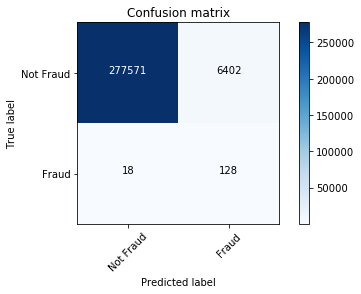

In [30]:
adaboost_undersample([folds[0]], full_test_set = True)

So what we see above is testing each fold's model on every data point that isn't included in the train set gives drastically different results. Now we have a problem where there's thousands of false positive flags. What's happening is adaboost is coming up with a great decision boundary for that area of the feature space. But we have a pretty vast 30 dimensional feature space to predict on.

Let's try to lower that using...

3. Ensembled model with undersampling.
----------------------------------------------------
First before we start making an ensemble, we need to create a CV set. If we ensembled all of our models currently, we would have no Class 1 instances left (all of them are used once or likely multiple times in the 10 training sets). 

In [31]:
def cv_setup(X_data, y_data):
    '''Returns X_data, y_data, X_cv, y_cv, ls_features
    X_cv, y_cv are randomized 10% of data with same class
    proportions'''
    
    
    pos_events = X_data[X_data['Class'] == 1]
    neg_events = X_data[X_data['Class'] == 0]
    number_pos_events, number_neg_events, number_events = (len(pos_events), 
                                                           len(neg_events),
                                                           len(X_data))
    pos_events = pos_events.reindex(np.random.permutation(pos_events.index))
    neg_events = neg_events.reindex(np.random.permutation(neg_events.index))
    X_cv = pd.concat([neg_events.tail(number_neg_events//10), 
                      pos_events.tail(number_pos_events//10)])
    y_cv = X_cv['Class']

    #Get rid of duplicates between CV and Test/Train bank of data
    X_data = pd.concat([X_cv, X_data])
    X_data = (X_data.reset_index()
                    .drop_duplicates(subset= 'index', keep= False)
                    .set_index('index'))
    y_data = X_data['Class']
    
    return X_data, y_data, X_cv, y_cv, ls_features

In [32]:
#Remake our folds without including 10% of the data for a CV set
X_data, y_data, X_cv, y_cv, ls_features = cv_setup(X_data, y_data)
folds = under_sample_kfold(X_data, y_data)

So let's see the results of an ensemble of 10 models (one derived from each fold of the data) tested on just the CV set.

Confusion matrix, without normalization


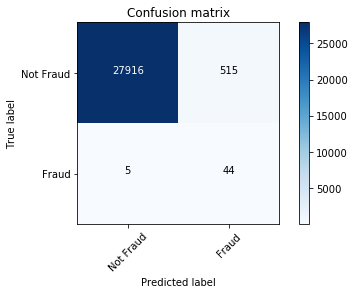

In [36]:
def adaboost_undersample_ensemble(folds):
    
    X_train_all_folds = pd.DataFrame()
    ada_ensemble = []
    
    for fold in folds:
        X_train, X_test, y_train, y_test = fold[0], fold[1], fold[2], fold[3]
    
        dt_clf = DecisionTreeClassifier(max_depth = 1)
        ada_real = AdaBoostClassifier(base_estimator = dt_clf, 
                                      learning_rate = 0.1, 
                                      n_estimators = 100)
        ada_real.fit(X_train[ls_features], y_train)
        #Concatenate all train sets and store each fold models
        X_train_all_folds = pd.concat([X_train_all_folds, X_train])
        ada_ensemble.append(ada_real)
    
    #Call scorer
    ensemble_score(X_cv, y_cv, ada_ensemble)

def ensemble_score(X_test, y_test, models, cutoff = 0.5, e_cutoff = 5):
    '''Prints confusion matrix for an ensemble of models based on 
    probability cutoff (cutoff) of each model and voting cutoff 
    (e_cutoff) for an ensemble vote. Default is >50% probability
    and > 5 votes out of 10'''
    
    for fold in range(0, len(models)):
        X_test.loc[:, ('Prob fold ' + str(fold))] = models[fold].predict_proba(X_test[ls_features])[:,1]
        X_test.loc[:, ('ADAPred fold ' + str(fold))] = (X_test[('Prob fold ' + str(fold))] >= cutoff).astype(int)
    
    X_test.loc[:, 'Ensemble Score'] = X_test[['ADAPred fold ' + str(i) for i in range(0, len(models))]].sum(axis = 1)
    X_test.loc[:, 'Ensemble Pred'] = (X_test['Ensemble Score'] > e_cutoff).astype(int)

    ensemble_conf = confusion_matrix(y_test, X_test[('Ensemble Pred')])
    plot_confusion_matrix(ensemble_conf, classes = ['Not Fraud', 'Fraud'])

adaboost_undersample_ensemble(folds)

Everything looks pretty good! The amount of false positives has dropped significantly, and we haven't sacrificed the sensitivity (true positive rate) of our model at all. 

Ensemble Validation
================
Let's try some ensemble validation before we go with this ensemble technique.

Validation on our ensemble technique is a bit tricky - we can change our ensemble parameters (probability cutoff, ensemble vote cutoff) but we can potentially overfit this technique to our CV set. To avoid this, we should reshuffle the data, redraw our CV set, retrain our kfold models, and retry our ensemble technique on the CV set.

Confusion matrix, without normalization


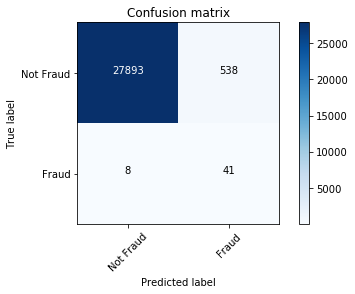

In [37]:
X_data, y_data, ls_features = classification_setup(df_data)
X_data, y_data, X_cv, y_cv, ls_features = cv_setup(X_data, y_data)
folds = under_sample_kfold(X_data, y_data)
adaboost_undersample_ensemble(folds)

Similar results! Again, this was meant to be an introduction to ensemble learning, a powerful technique for skewed data sets. Some key things to keep in mind:

1. When undersampling to train a model, make sure to validate it with a real test set, not an "undersampled" test set.
2. When developing an ensemble technique, use a CV set. It's very likely you'll run out of the minority class when you use slices of the data to create several unique models, even if the data for each model is chosen at random.
3. Be sure to validate your ensemble technique by reshuffling your data and redrawing a new CV set.

